In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Cross-validation

One of the primary challenges in time series forecasting is the inherent uncertainty and variability over time, making it crucial to validate the accuracy and reliability of the models employed. Cross-validation, a robust model validation technique, is particularly adapted for this task, as it provides insights into the expected performance of a model on unseen data, ensuring the forecasts are reliable and resilient before being deployed in real-world scenarios.

`TimeGPT`, understanding the intricate needs of time series forecasting, incorporates the `cross_validation` method, designed to streamline the validation process for time series models. This functionality enables practitioners to rigorously test their forecasting models against historical data, assessing their effectiveness while tuning them for optimal performance. This tutorial will guide you through the nuanced process of conducting cross-validation within the `NixtlaClient` class, ensuring your time series forecasting models are not just well-constructed, but also validated for trustworthiness and precision.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/08_cross_validation')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/08_cross_validation.ipynb)

## 1. Import packages
First, we install and import the required packages and initialize the Nixtla client.

We start off by initializing an instance of `NixtlaClient`.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

from IPython.display import display

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(
>         base_url="you azure ai endpoint",
>         api_key="your api_key"`
>)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

Let's see an example, using the Peyton Manning dataset.

In [ ]:
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')

## 3. Cross-validation

The `cross_validation` method within the `TimeGPT` class is an advanced functionality crafted to perform systematic validation on time series forecasting models. This method necessitates a dataframe comprising time-ordered data and employs a rolling-window scheme to meticulously evaluate the model's performance across different time periods, thereby ensuring the model's reliability and stability over time. The animation below shows how TimeGPT performs cross-validation.

<img src="https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif" alt="Rolling-window cross-validation" /> 

Key parameters include `freq`, which denotes the data's frequency and is automatically inferred if not specified. The `id_col`, `time_col`, and `target_col` parameters designate the respective columns for each series' identifier, time step, and target values. The method offers customization through parameters like `n_windows`, indicating the number of separate time windows on which the model is assessed, and `step_size`, determining the gap between these windows. If `step_size` is unspecified, it defaults to the forecast horizon `h`. 

The process also allows for model refinement via `finetune_steps`, specifying the number of iterations for model fine-tuning on new data. Data pre-processing is manageable through `clean_ex_first`, deciding whether to cleanse the exogenous signal prior to forecasting. Additionally, the method supports enhanced feature engineering from time data through the `date_features` parameter, which can automatically generate crucial date-related features or accept custom functions for bespoke feature creation. The `date_features_to_one_hot` parameter further enables the transformation of categorical date features into a format suitable for machine learning models.

In execution, `cross_validation` assesses the model's forecasting accuracy in each window, providing a robust view of the model's performance variability over time and potential overfitting. This detailed evaluation ensures the forecasts generated are not only accurate but also consistent across diverse temporal contexts.

In [ ]:
timegpt_cv_df = nixtla_client.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
)
timegpt_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,timestamp,cutoff,value,TimeGPT
0,2015-12-17,2015-12-16,7.591862,7.939553
1,2015-12-18,2015-12-16,7.528869,7.887512
2,2015-12-19,2015-12-16,7.171657,7.766617
3,2015-12-20,2015-12-16,7.891331,7.931502
4,2015-12-21,2015-12-16,8.360071,8.312632


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.cross_validation(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

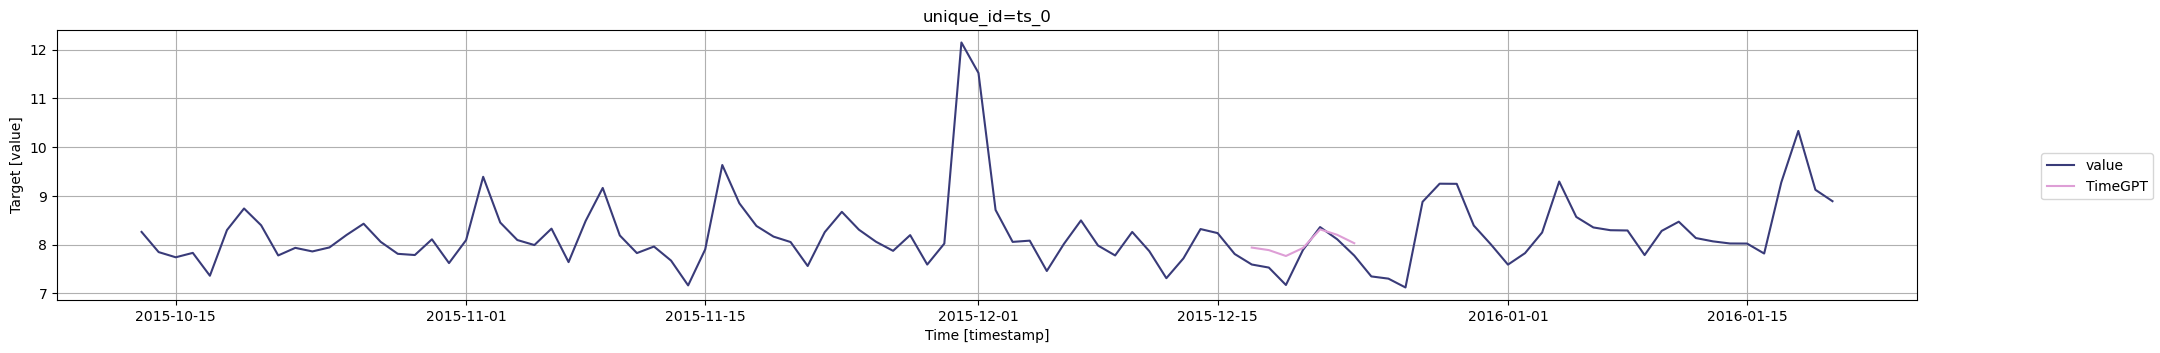

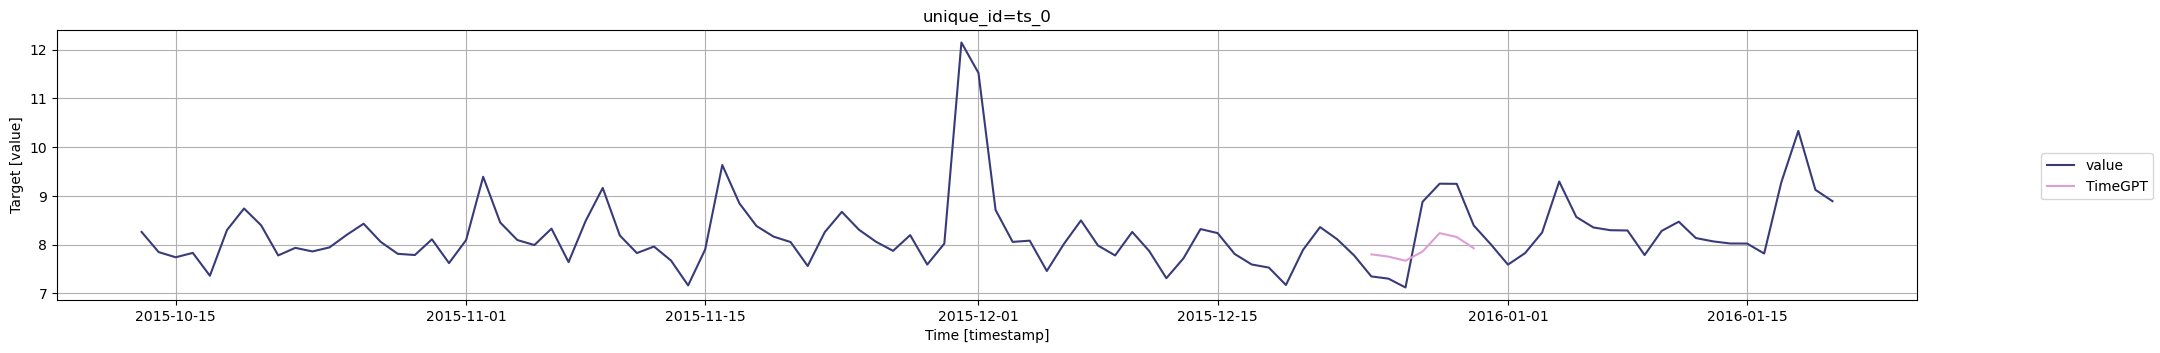

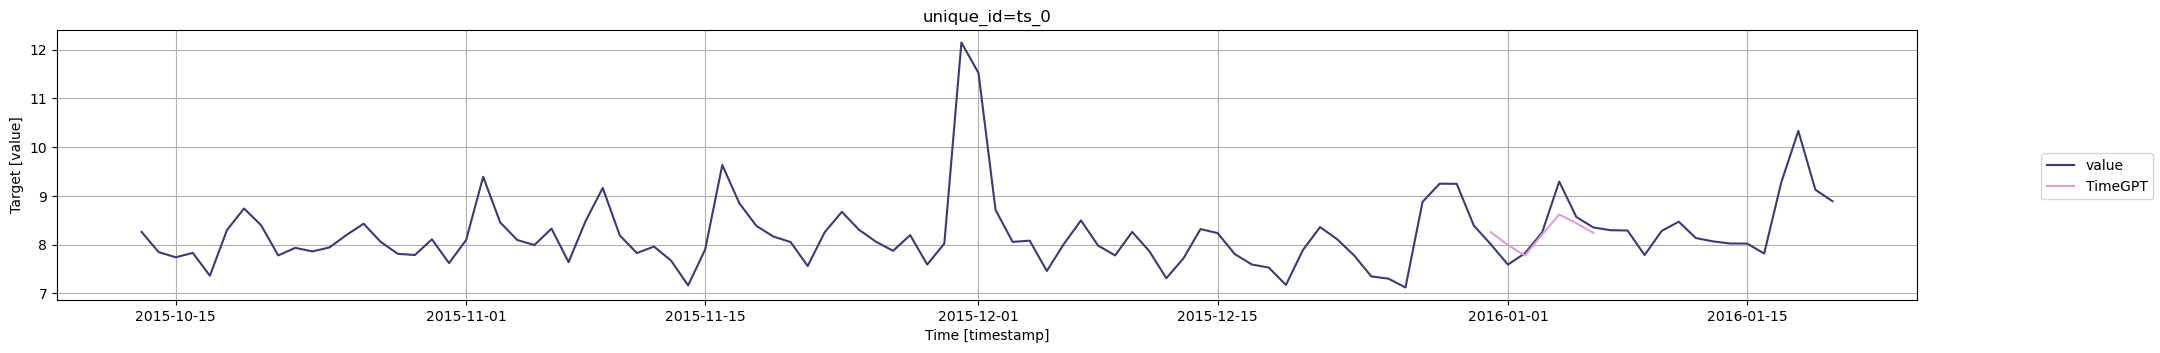

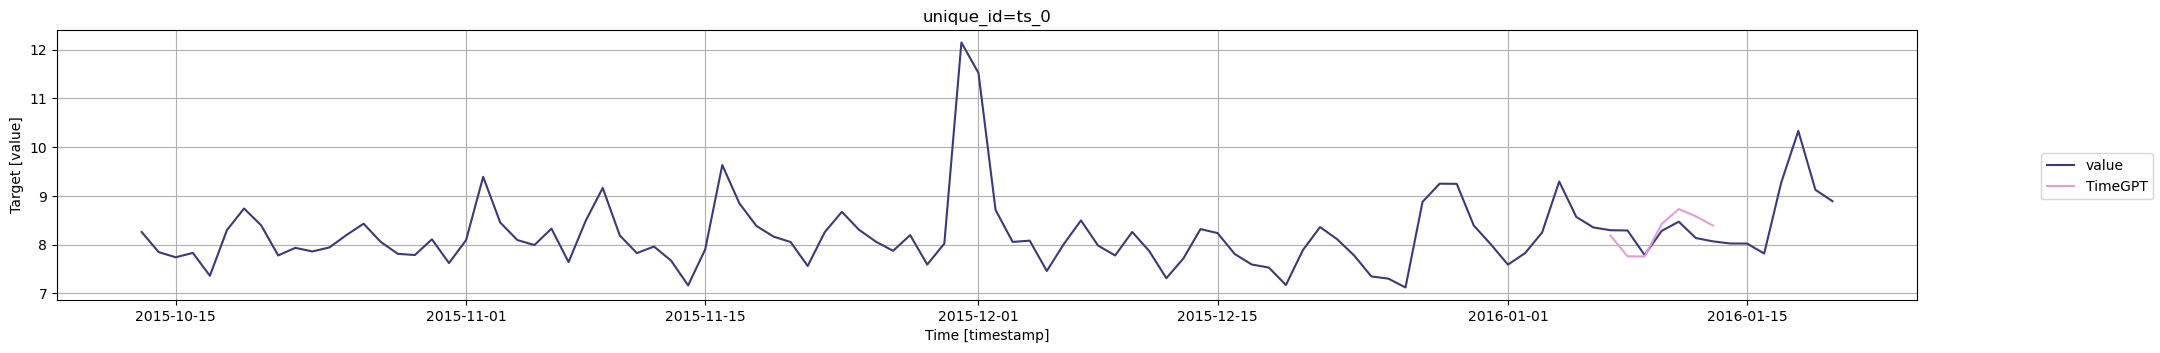

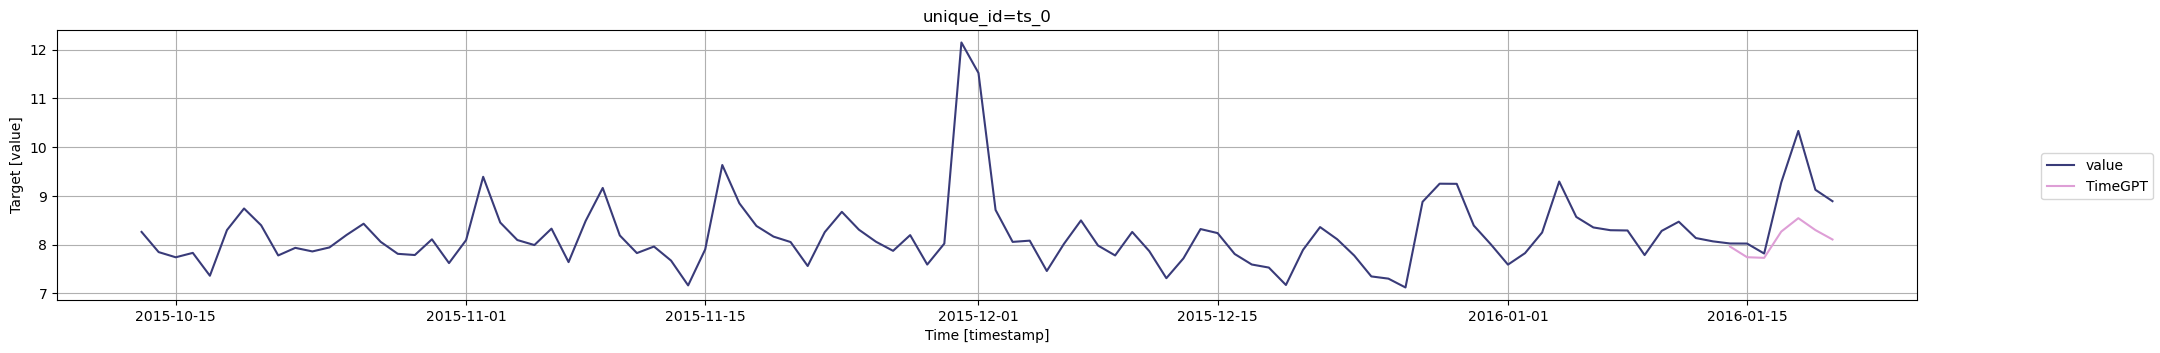

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value'
    )
    display(fig)

## 4. Cross-validation with prediction intervals

It is also possible to generate prediction intervals during cross-validation. To do so, we simply use the `level` argument.

In [ ]:
timegpt_cv_df = nixtla_client.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
    level=[80, 90],
)
timegpt_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,timestamp,cutoff,value,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2015-12-17,2015-12-16,7.591862,7.939553,7.564151,7.675945,8.203161,8.314956
1,2015-12-18,2015-12-16,7.528869,7.887512,7.567342,7.598298,8.176726,8.207681
2,2015-12-19,2015-12-16,7.171657,7.766617,7.146560,7.266829,8.266404,8.386674
3,2015-12-20,2015-12-16,7.891331,7.931502,7.493021,7.657075,8.205929,8.369982
4,2015-12-21,2015-12-16,8.360071,8.312632,7.017335,7.446677,9.178586,9.607928


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.cross_validation(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

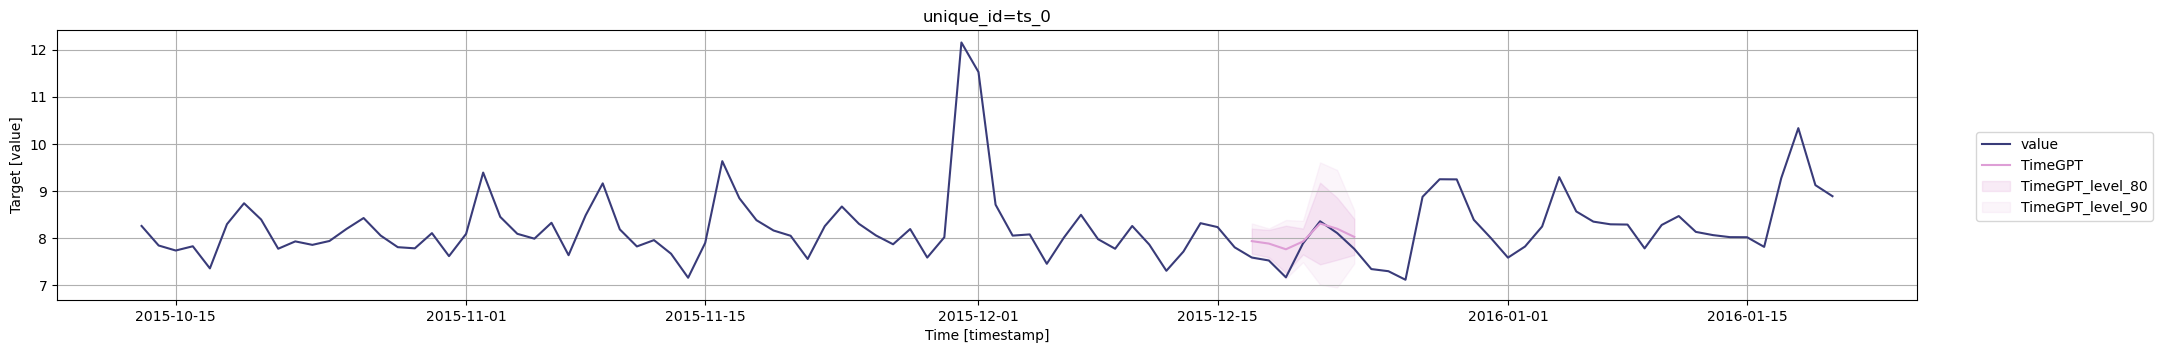

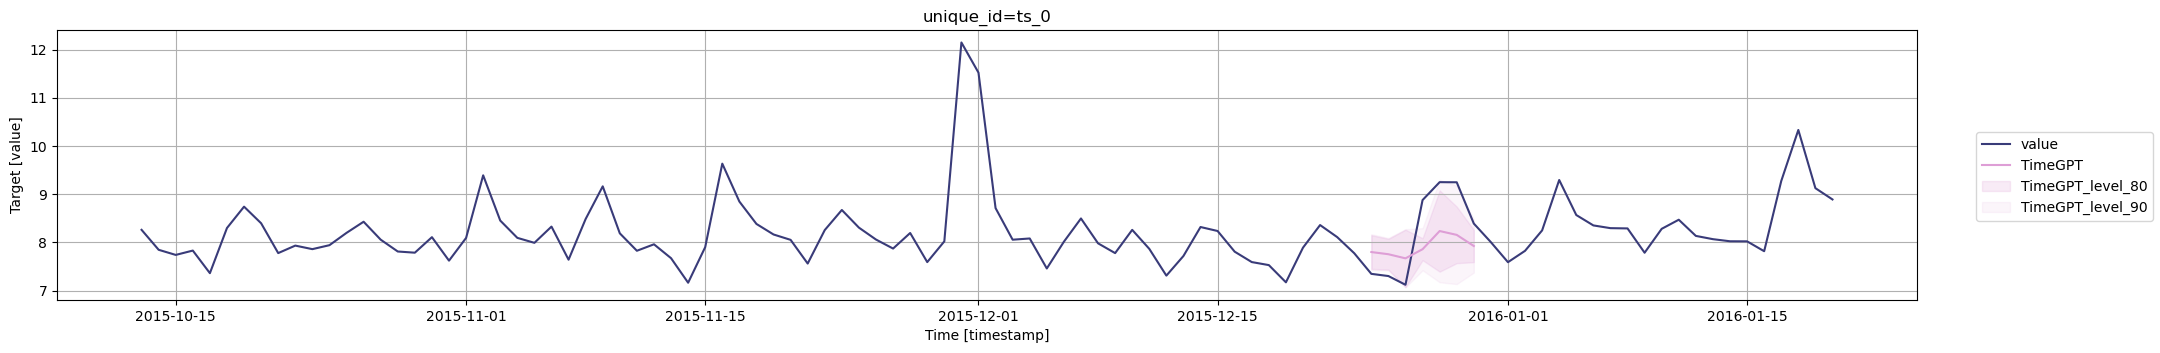

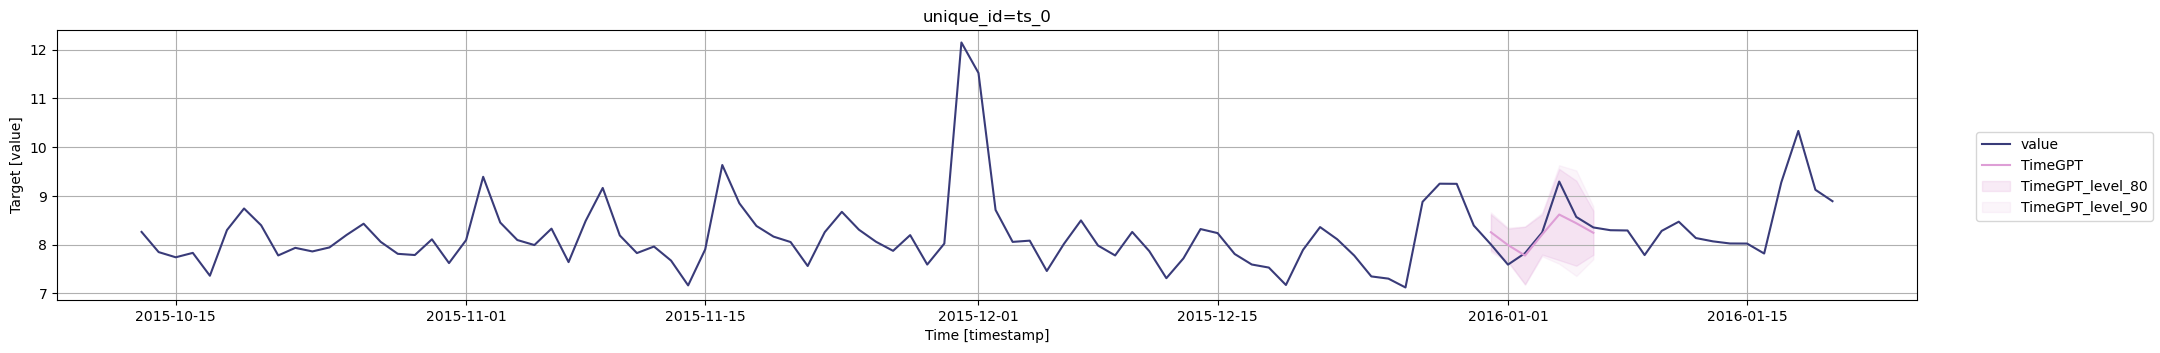

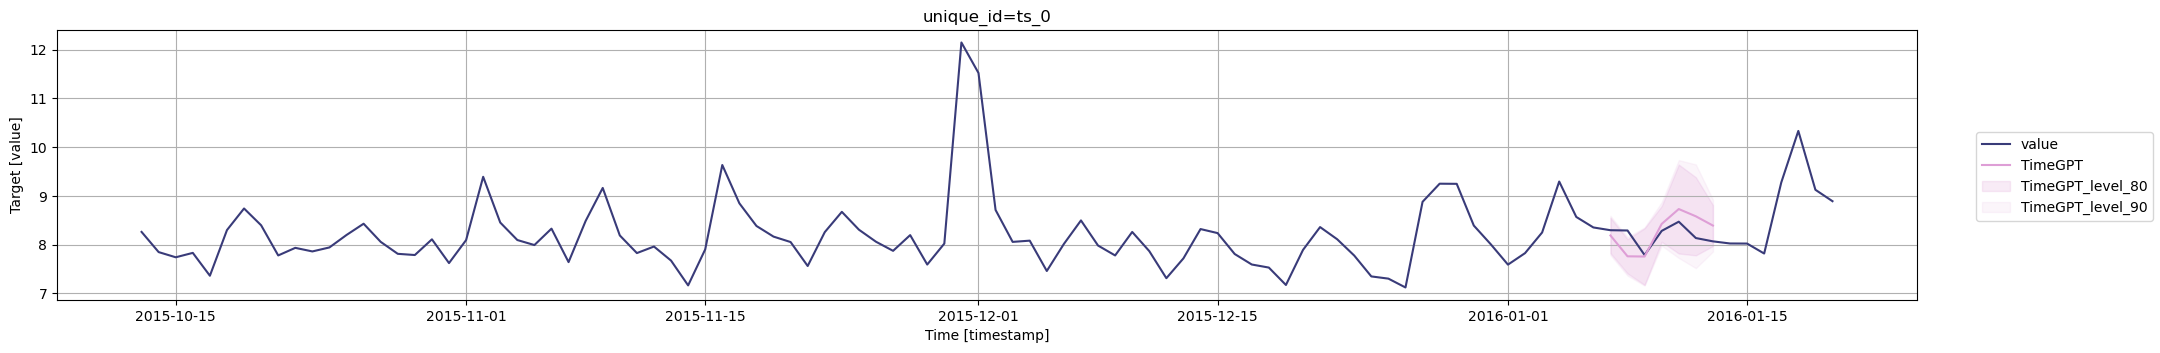

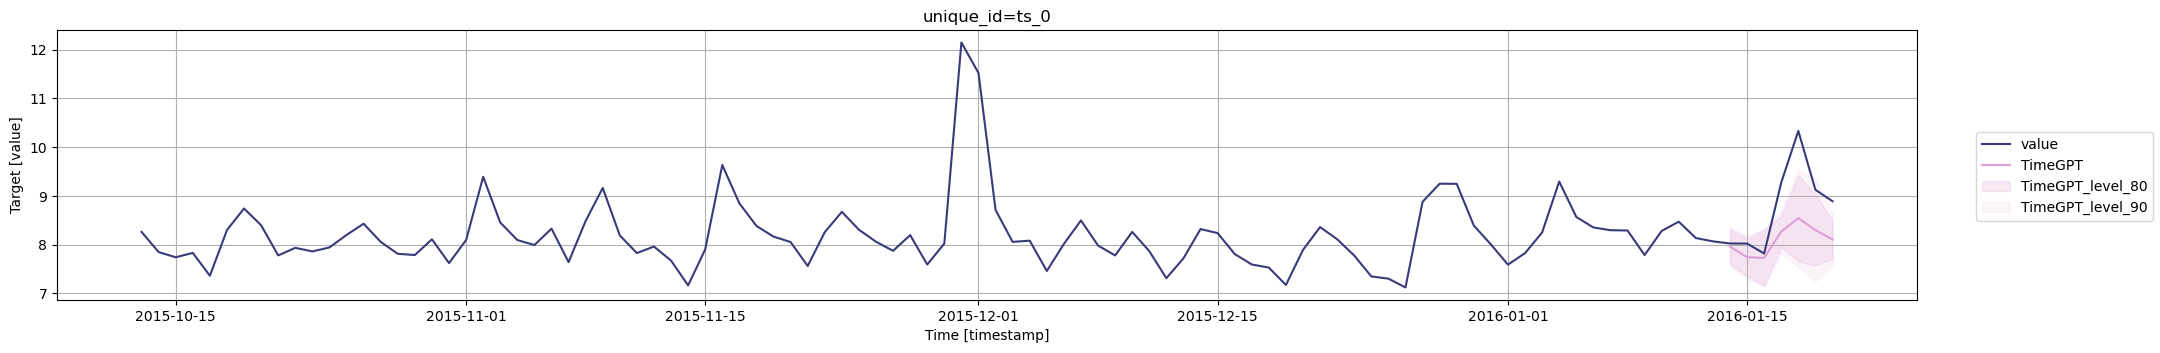

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value',
        level=[80, 90],
        models=['TimeGPT']
    )
    display(fig)

## 5. Cross-validation with exogenous variables

### Time features

It is possible to include exogenous variables when performing cross-validation. Here we use the `date_features` parameter to create labels for each month. These features are then used by the model to make predictions during cross-validation.

In [ ]:
timegpt_cv_df = nixtla_client.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
    level=[80, 90],
    date_features=['month'],
)
timegpt_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,timestamp,cutoff,value,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2015-12-17,2015-12-16,7.591862,7.931697,7.528752,7.634238,8.229156,8.334641
1,2015-12-18,2015-12-16,7.528869,7.879933,7.258649,7.468433,8.291433,8.501217
2,2015-12-19,2015-12-16,7.171657,7.759708,7.101670,7.269838,8.249578,8.417745
3,2015-12-20,2015-12-16,7.891331,7.921784,6.970479,7.327653,8.515915,8.873088
4,2015-12-21,2015-12-16,8.360071,8.302374,7.122366,7.640518,8.964230,9.482381


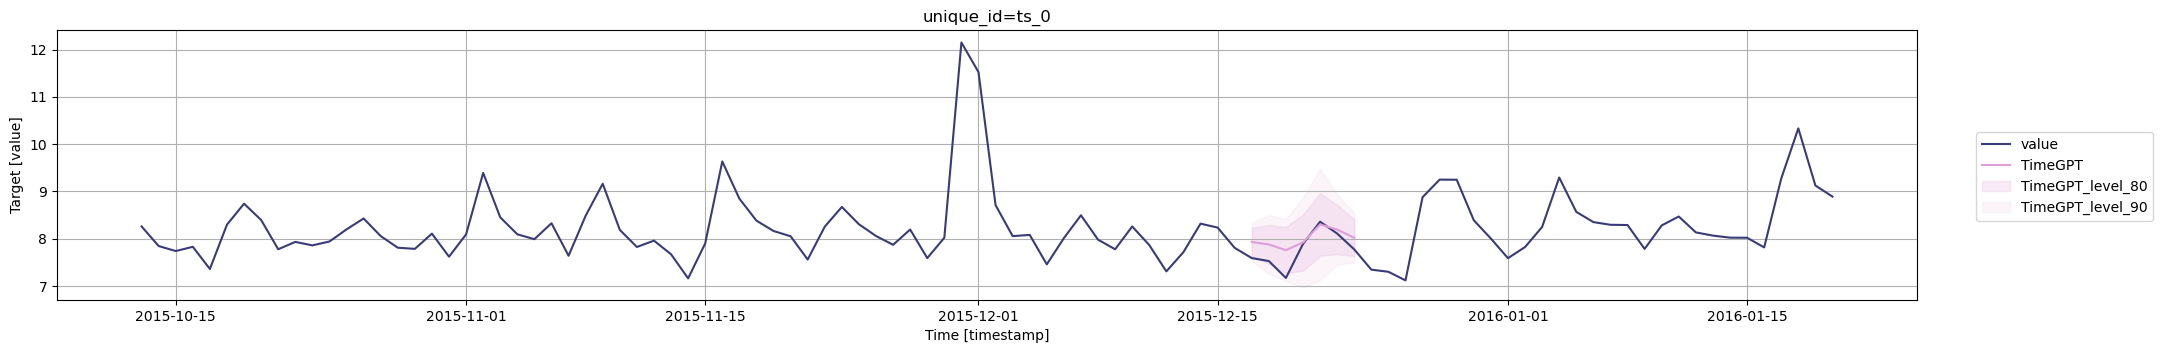

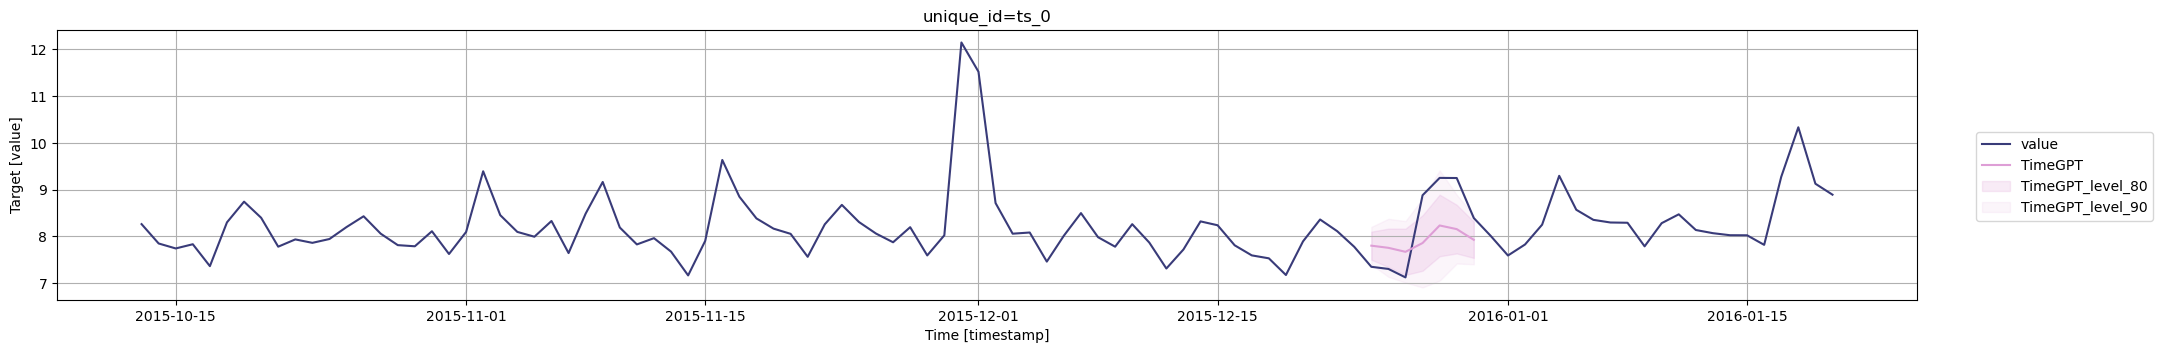

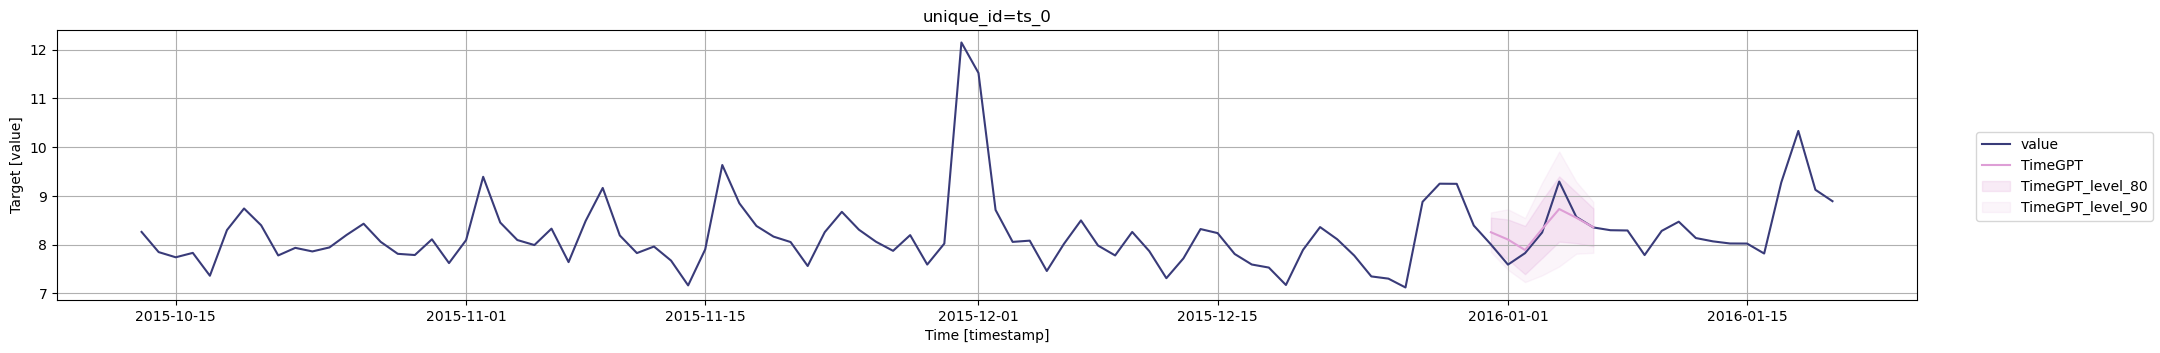

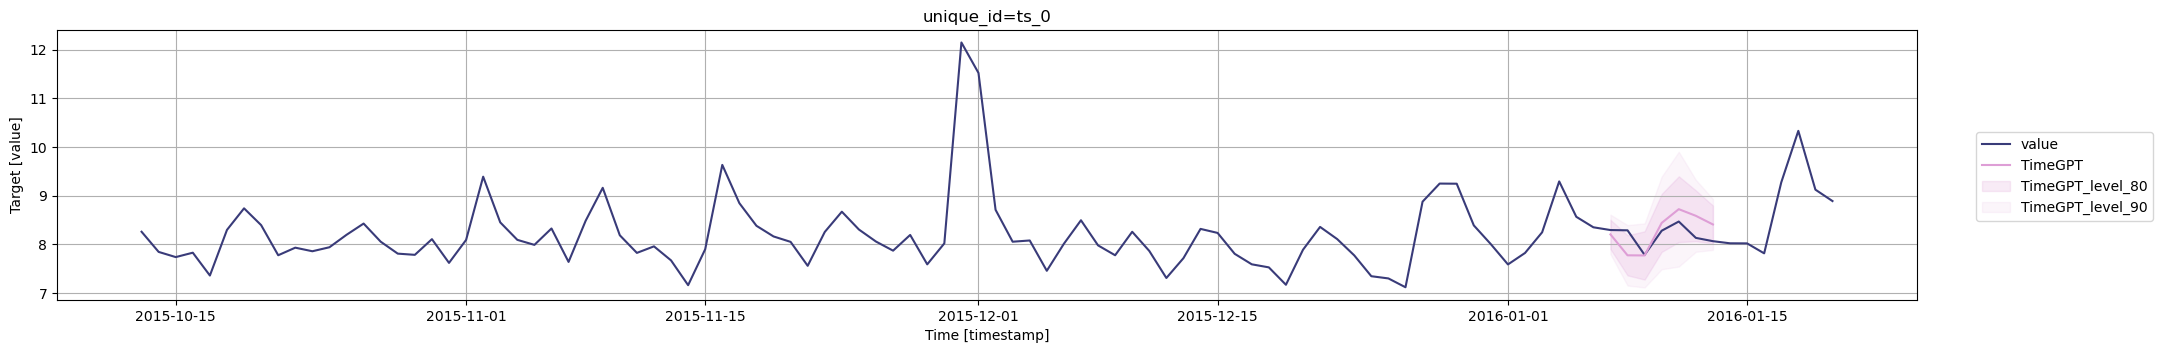

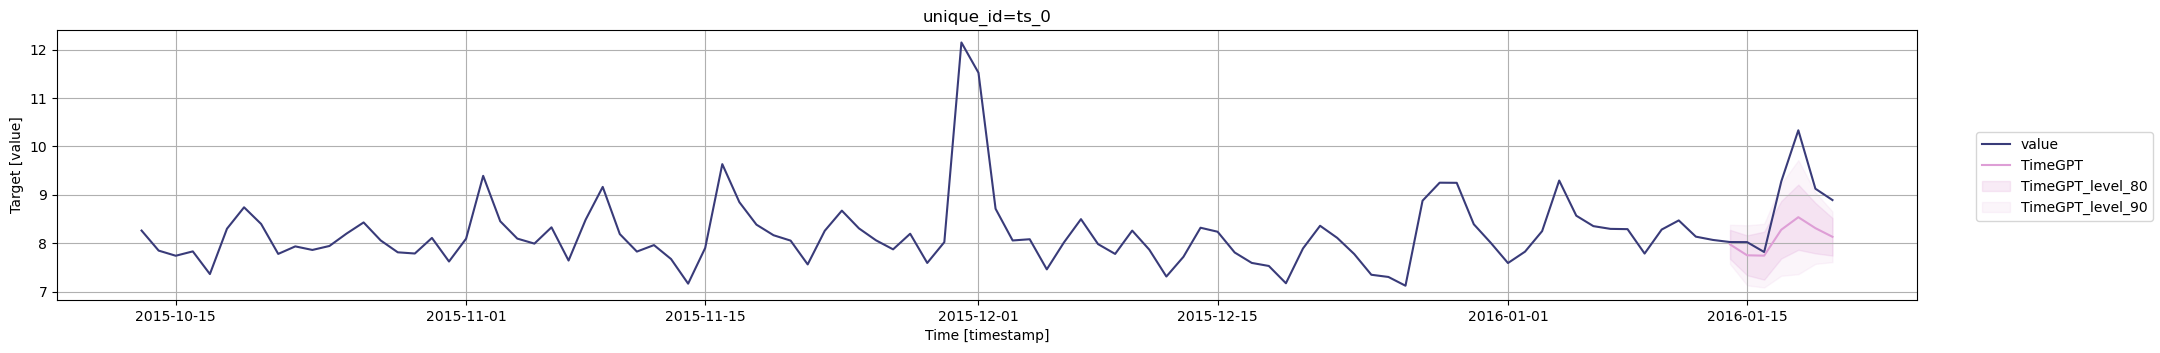

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value',
        level=[80, 90],
        models=['TimeGPT']
    )
    display(fig)

### Dynamic features

Additionally you can pass dynamic exogenous variables to better inform `TimeGPT` about the data. You just simply have to add the exogenous regressors after the target column.

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity.csv')
X_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/exogenous-vars-electricity.csv')
df = Y_df.merge(X_df)

Now let's cross validate `TimeGPT` considering this information

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient(max_retries=2, retry_interval=5)

INFO:nixtla.nixtla_client:Validating inputs...


INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


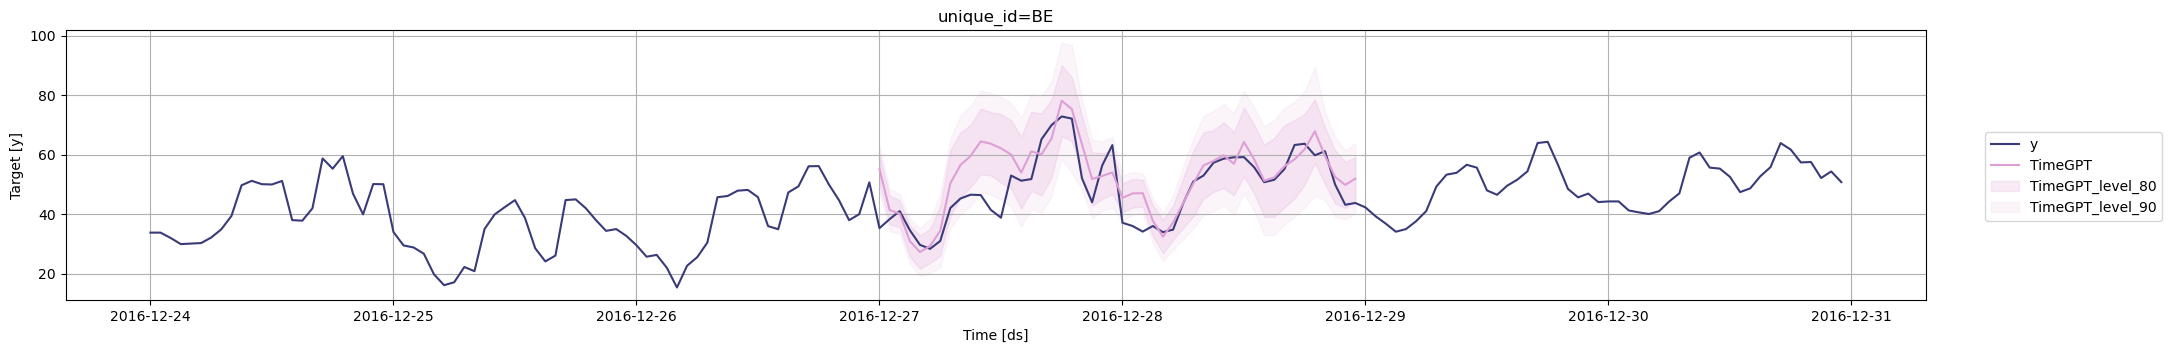

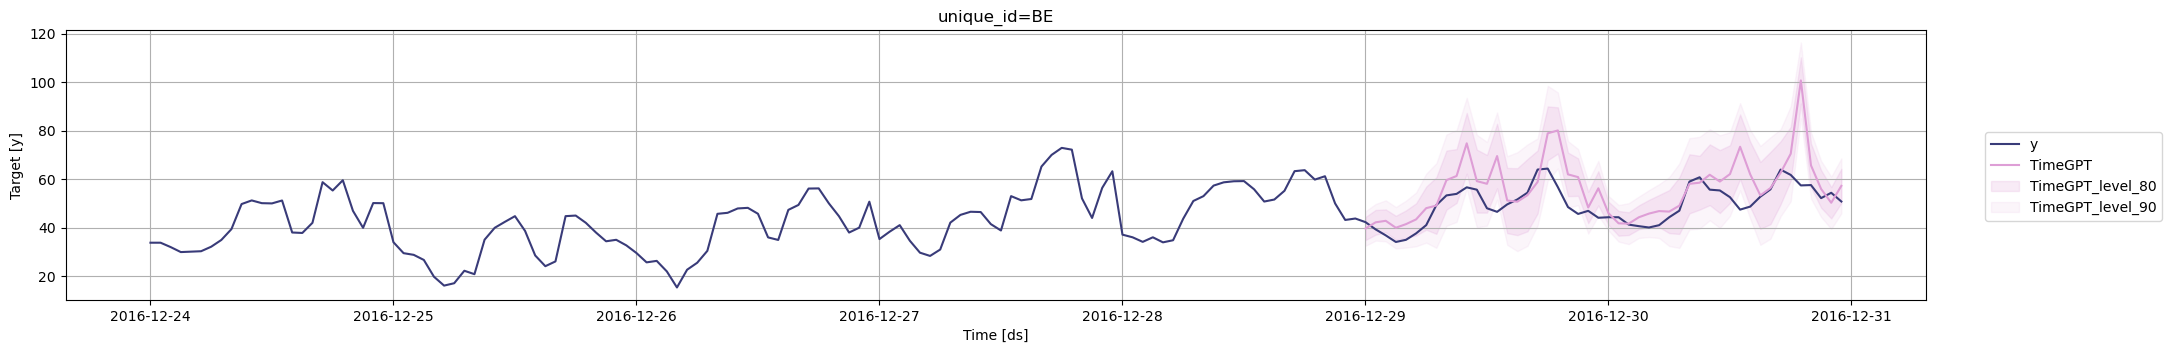

In [ ]:
timegpt_cv_df_x = nixtla_client.cross_validation(
    df.groupby('unique_id').tail(100 * 48), 
    h=48, 
    n_windows=2,
    level=[80, 90]
)
cutoffs = timegpt_cv_df_x.query('unique_id == "BE"')['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        df.query('unique_id == "BE"').tail(24 * 7), 
        timegpt_cv_df_x.query('cutoff == @cutoff & unique_id == "BE"').drop(columns=['cutoff', 'y']),
        models=['TimeGPT'],
        level=[80, 90],
    )
    display(fig)

> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.cross_validation(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

## 6. Cross-validation with different TimeGPT instances

Also, you can generate cross validation for different instances of `TimeGPT` using the `model` argument. Here we use the base model and the model for long-horizon forecasting.

INFO:nixtla.nixtla_client:Validating inputs...


INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


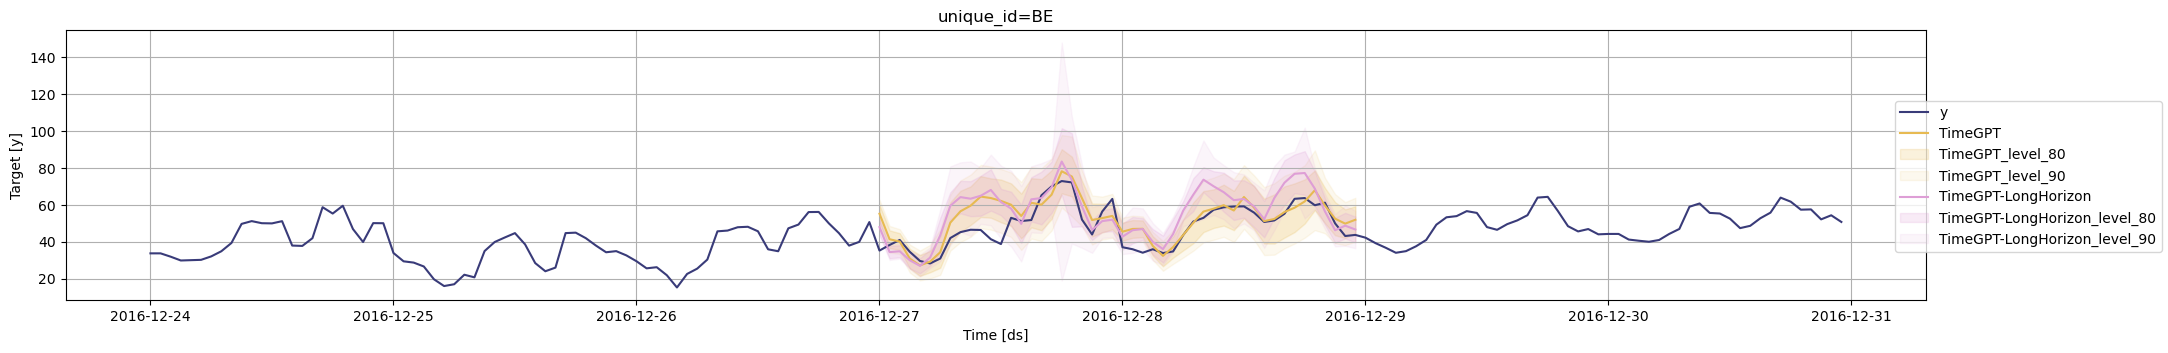

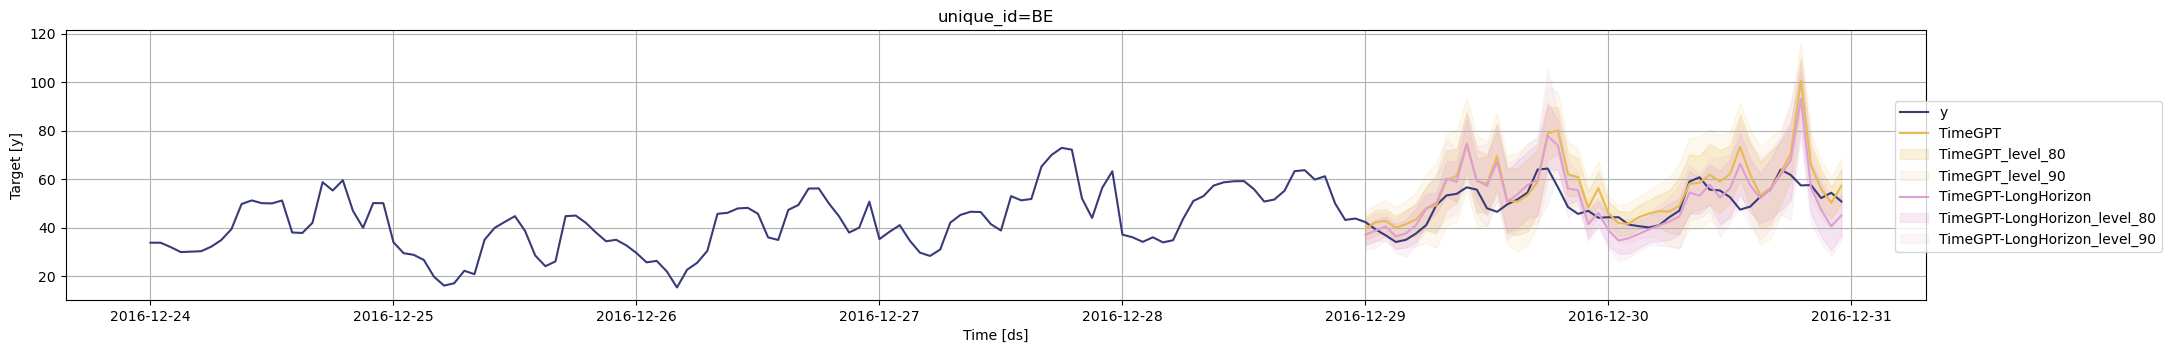

In [ ]:
timegpt_cv_df_x_long_horizon = nixtla_client.cross_validation(
    df.groupby('unique_id').tail(100 * 48), 
    h=48, 
    n_windows=2,
    level=[80, 90],
    model='timegpt-1-long-horizon',
)
timegpt_cv_df_x_long_horizon.columns = timegpt_cv_df_x_long_horizon.columns.str.replace('TimeGPT', 'TimeGPT-LongHorizon')
timegpt_cv_df_x_models = timegpt_cv_df_x_long_horizon.merge(timegpt_cv_df_x)
cutoffs = timegpt_cv_df_x_models.query('unique_id == "BE"')['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        df.query('unique_id == "BE"').tail(24 * 7), 
        timegpt_cv_df_x_models.query('cutoff == @cutoff & unique_id == "BE"').drop(columns=['cutoff', 'y']),
        models=['TimeGPT', 'TimeGPT-LongHorizon'],
        level=[80, 90],
    )
    display(fig)

> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.cross_validation(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.